In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pybullet as p
from scipy.spatial.transform import Rotation
import pandas as pd
import pickle
with open('poses.pickle', 'rb') as handle: poses = pickle.load(handle)

def get_gravity_vec(rpdata):
    q = p.getQuaternionFromEuler([rpdata[0],rpdata[1],0])
    rot_ = Rotation.from_quat(q)
    mat_ = rot_.as_matrix()
    vec_ = np.dot(np.transpose(mat_), np.array([[0.], [0.], [-1.]]))
    vec_ = np.reshape(vec_,(-1,)).tolist()
    return vec_

import os
accessTimeFiles = ['accessTimeTable%d.npy'%x for x in range(14)]
timeMat = np.sum([np.load(f) for f in accessTimeFiles],axis=0)
timeMat[range(len(timeMat)),range(len(timeMat))]= 0 

pybullet build time: May 20 2022 19:44:17


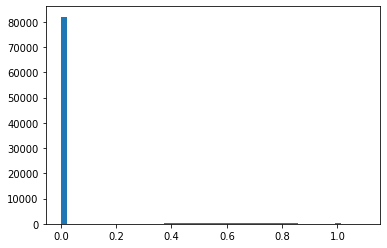

In [2]:
weight_matrix = (timeMat < 19.999) * np.exp(-timeMat/20) + (timeMat >= 19.999) * 1e-8
values = np.reshape(weight_matrix,(-1,))
ax = plt.hist(values,bins=50,range=(-1e-4,1.1))

49 15.822355543670485


(0.0, 101.0)

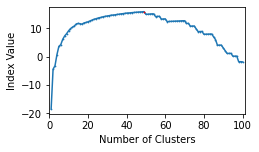

In [3]:
# do clustering
class K_access:
    def __init__(self, access, k=2, seed =123):
        self.seed = seed
        np.random.seed(self.seed)
        self.k = k
        self.access = access
        self.node_num = len(access)
        self.access[range(self.node_num),range(self.node_num)] = 1
        self.core_index = np.zeros((k,),dtype=int)
        
        self.core_index[0] = np.random.randint(0, self.node_num, (1,))
        for i in range(1,k):
            ready_core_access = np.sum(self.access[self.core_index[:i],:],axis=0) + np.sum(self.access[:,self.core_index[:i]],axis=1)
            ready_core_access[self.core_index[:i]] += 999999 # accessible to self
            self.core_index[i] = np.argmin(ready_core_access) # the one that is the farthest from 
            
        self.assignment = np.zeros((self.node_num,),dtype=int)
        self.labels = np.zeros((self.node_num,),dtype=int)
        self.cores_sorted = np.zeros((self.node_num,),dtype=int)
        self.assign()
        self.max_iter = 10000
            
    def assign(self):
        core_access = self.access[self.core_index] # from core to nodes
        self.assignment = self.core_index[np.argmax(core_access, axis = 0)] # argmax access(core,node)
        for c in self.core_index:
            self.assignment[c] = c  # self belongs to self
        return
    
    def update(self):
        for i in range(self.k):
            Si = np.where(self.assignment == self.core_index[i])[0]
            access_Si = self.access[Si,:][:,Si]
            minaccess_Si = np.min(access_Si,axis=1)
            self.core_index[i] = Si[np.argmax(minaccess_Si)]
        return        
    
    def fit(self):
        pre_assignment = np.zeros((self.node_num,),dtype=int) - 1
        iter_ = 0
        while np.sum(np.abs(self.assignment - pre_assignment)) != 0 and iter_ < self.max_iter :
            pre_assignment = self.assignment
            iter_ += 1
            self.update()
            self.assign()
        return iter_
            
    def predict(self):
        map_ = {}
        cnt_Si = []
        for i in range(self.k):
            cnt_Si.append(len(np.where(self.assignment == self.core_index[i])[0]))
        sorted_index = (9999 - np.array(cnt_Si)).argsort()  # descending by # samples in clu
        for i in range(self.k):
            map_[self.core_index[sorted_index[i]]] = i+1 ##    from 1 to # clu
        self.labels = [map_[c] for c in self.assignment]
        cores_sorted = self.core_index[sorted_index]
        return self.labels, cores_sorted 
    
    def inter_access(self):
        cnt_Si = []
        for i in range(self.k):
            cnt_Si.append(len(np.where(self.assignment == self.core_index[i])[0]))
        sorted_index = (9999 - np.array(cnt_Si)).argsort()  # descending by # samples in clu
        all_to_C = self.access[:,:][:,self.core_index[sorted_index]]
        inter_ = np.zeros((self.k,self.k))
        for i in range(self.k):
            Si = np.where(self.assignment == self.core_index[sorted_index[i]])[0]
            Si_to_C = all_to_C[Si,:]
            inter_[i,:] = np.mean(Si_to_C,axis = 0)
            inter_[i,i] = 1
        return inter_
    
    def intra_access(self):
        intra_ = np.zeros((self.k,))
        cnt_Si = []
        for i in range(self.k):
            cnt_Si.append(len(np.where(self.assignment == self.core_index[i])[0]))
        sorted_index = (9999 - np.array(cnt_Si)).argsort()  # descending by # samples in clu
        for i in range(self.k):
            Si = np.where(self.assignment == self.core_index[sorted_index[i]])[0]
            intra_[i] = np.min(self.access[self.core_index[sorted_index[i]],Si],axis=0)
        return intra_
    
    def evaluate(self):
        intra_ = np.mean(np.log(self.intra_access()))
        inter_ = np.mean(np.log(self.inter_access()))
        cnt_Si = []
        for i in range(self.k):
            cnt_Si.append(len(np.where(self.assignment == self.core_index[i])[0]))
        num_one_sample_cluster = len(np.where(np.array(cnt_Si)==1)[0])
        alpha = 1
        score_ = intra_ - inter_ - alpha * num_one_sample_cluster # larger is better
        return score_

scores = []
n_cls = range(1,101)
for num_class in n_cls:
    k = K_access(weight_matrix, num_class)
    k.fit()
    scores.append(k.evaluate())
    

fig,ax = plt.subplots(figsize=(3.5,3.5*9/16))

max_ind = np.argmax(scores)
print(max_ind+1,scores[max_ind])

plt.plot(n_cls,scores,marker='o',markersize=.75)
plt.plot([max_ind+1],[scores[max_ind]],marker='o',c='r',markersize=.8)
plt.xlabel('Number of Clusters')
plt.ylabel('Index Value')
plt.xlim([0,101])

In [4]:
num_class = max_ind+1
k = K_access(weight_matrix, num_class)
k.fit()
clusters, cores = k.predict()
inter_access = k.inter_access()
intra_access = k.intra_access()

In [5]:
np.max(clusters)

49

49


Text(0, 0.5, 'Number of Samples')

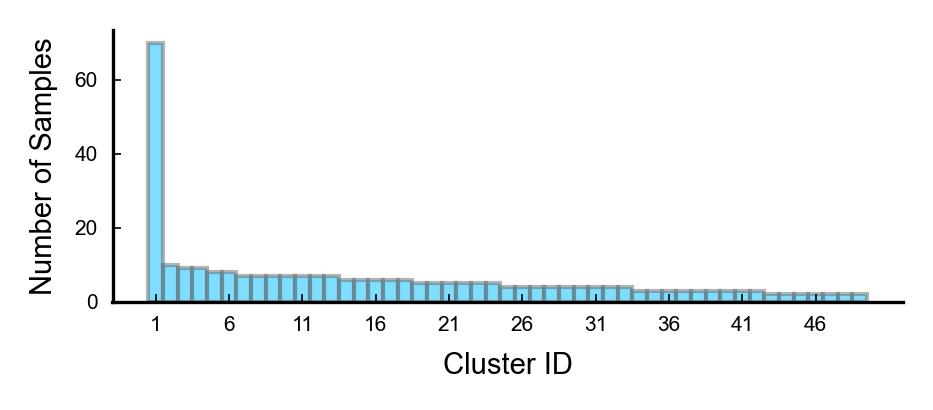

In [6]:
# min(cluster) = 1
plt.rcParams['figure.dpi'] = 300
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 5}

plt.rc('font', **font)
plt.rcParams['lines.linewidth']=0.7
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.width']=0.4
plt.rcParams['ytick.major.width']=0.4
plt.rcParams['xtick.major.size']=2
plt.rcParams['ytick.major.size']=2
fig,ax = plt.subplots(figsize=(3.4,1.2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_ = plt.hist(np.array(clusters)-0.5,range = [0.5,np.max(clusters)+0.5],bins = np.max(clusters),edgecolor='dimgray',color='deepskyblue',rwidth=1,alpha=0.5)
num_c_real = 0
for i in range(np.max(clusters)):
    if ax_[0][i] > 0:
        num_c_real+=1
#         plt.annotate(s=int(ax_[0][i]), xy=(ax_[1][i], ax_[0][i]))
ax = plt.xticks(range(1,1+np.max(clusters),5))
print(num_c_real)

plt.xlabel('Cluster ID',fontsize=7)
plt.ylabel('Number of Samples',fontsize=7)


In [9]:
"""
output format: list of tuples:
[
([0,0,height], [ 12 joints], [roll, pitch, 0] ),
]
"""
kaccess_config = []
for i in range(np.max(clusters)):
    centroid_pose = poses[cores[i]]
    ele1 = [0,0, centroid_pose['store_height']]
    ele2 = centroid_pose['store_joints']
    ele3 = list(centroid_pose['store_roll_pitch'])+[0]
    ele = (ele1,ele2,ele3)
    kaccess_config.append(ele)
print(kaccess_config)

[([0, 0, 0.0912189957324243], [0.504355606805779, 3.6905439925317842, -2.6812761530806974, 0.028245387586753067, 1.1393844578804382, -2.3066327093680083, -0.5545440516756344, 0.7870168279430291, -1.019563013501047, -0.1529390574914711, 1.6145625035401459, -1.444521577928498], [-2.9493814930426847, -0.12245102485230747, 0]), ([0, 0, 0.37703775847139165], [-0.2315423057943387, 3.238844516945993, -1.2784669395711306, -0.2631360018318235, 2.049493041918246, -1.6048817294018758, 0.4803791526296773, 1.1258617118225456, -2.2094770217721913, -0.28692072518887346, 1.8812256679395125, -2.0796585096887608], [-0.3166943384007275, -1.3984366534764578, 0]), ([0, 0, 0.1413193321665558], [0.40017223497641863, 0.35616769485146704, -1.3687706234134422, -0.8029378798047949, 0.020551989315046967, -1.870934570563669, -0.24317057580050108, 0.23172645307910478, -1.5481008649545904, 0.2804814903834181, 3.3199473635032013, -1.9445960129799544], [-3.0577140207110074, 0.4582911262144125, 0]), ([0, 0, 0.180324742